# Valeurs des machins

In [8]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath, ufloat_fromstr
from options import *
from pathlib import Path

mpl.rcParams.update(rcParams)

In [9]:
fits = {}

with open('fits.csv', 'r') as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith('G'):
            name, a, b = line.replace('\n', '').split(',')
            fits[name] = [ufloat_fromstr(a), ufloat_fromstr(b)]

fits

{'G1-anneau': [0.00867+/-0.00024, -0.2342+/-0.0017],
 'G1-cylindre-acier-argent-chrome': [0.03972+/-0.00021, -0.023+/-0.0012],
 'G1-cylindre-acier-doux': [0.0474+/-0.00015, 0.0192+/-0.0008],
 'G1-cylindre-alu': [0.019027+/-5e-06, 0.000694+/-1e-05],
 'G1-cylindre-cuivre': [0.018744+/-2.5e-05, 0.002112+/-3.2e-05],
 'G1-cylindre-laiton': [0.019291+/-5e-06, -0.00084+/-7e-06],
 'G1-cylindre-monel400': [0.020996+/-1.2e-05, -0.026+/-7e-05],
 'G1-cylindre-nickel200': [0.021185+/-2.4e-05, -0.02978+/-0.00013],
 'G1-cylindre-vide': [0.01913+/-6e-06, 9.2e-05+/-7e-06],
 'G1-phywe-acdoux-combo': [0.0896+/-0.0005, 0.0169+/-0.0015],
 'G1-phywe-acdoux': [0.0798+/-0.00027, 0.0524+/-0.0011],
 'G1-phywe-alu-combo': [0.07529+/-6e-05, 0.00083+/-4e-05],
 'G1-phywe-alu': [0.07436+/-5e-05, 0.00336+/-4e-05],
 'G1-phywe-avec-bloc-horiz': [0.04399+/-0.00028, -0.0419+/-0.0009],
 'G1-phywe-avec-bloc-penche': [0.0579+/-0.0004, -0.0113+/-0.0014],
 'G1-phywe-avec-bloc': [0.0904+/-0.0006, 0.0109+/-0.001],
 'G1-phywe-cu

In [10]:
print(fits.get('G1-phywe-vide'))

[0.06899+/-8e-05, 0.000869+/-8e-06]


# Calcul $\mu_r$

## PHYWE

In [11]:
alph_phywe = fits.get('G1-phywe-vide')[0]

def mu_r(fit):
    return fit[0]/alph_phywe

mu = {}

for key, values in fits.items():
    if "G1-phywe" in key:
        temp_mu = mu_r(values)
        mu.update({key: temp_mu})
        print(f"{key}: mu_r = {temp_mu}")
        

G1-phywe-acdoux-combo: mu_r = 1.299+/-0.007
G1-phywe-acdoux: mu_r = 1.157+/-0.004
G1-phywe-alu-combo: mu_r = 1.0913+/-0.0015
G1-phywe-alu: mu_r = 1.0778+/-0.0014
G1-phywe-avec-bloc-horiz: mu_r = 0.638+/-0.004
G1-phywe-avec-bloc-penche: mu_r = 0.839+/-0.006
G1-phywe-avec-bloc: mu_r = 1.310+/-0.009
G1-phywe-cuivre-combo: mu_r = 1.0997+/-0.0015
G1-phywe-cuivre: mu_r = 1.0831+/-0.0013
G1-phywe-vide: mu_r = 1.0+/-0


## Cylindre

In [12]:
alph_cyl = fits.get('G1-cylindre-vide')[0]

def mu_r(fit):
    return fit[0]/alph_cyl


for key, values in fits.items():
    if "G1-cylindre" in key:
        temp_mu = mu_r(values)
        mu.update({key: temp_mu})
        print(f"{key}: mu_r = {temp_mu}")

G1-cylindre-acier-argent-chrome: mu_r = 2.076+/-0.011
G1-cylindre-acier-doux: mu_r = 2.478+/-0.008
G1-cylindre-alu: mu_r = 0.9946+/-0.0004
G1-cylindre-cuivre: mu_r = 0.9798+/-0.0013
G1-cylindre-laiton: mu_r = 1.0084+/-0.0004
G1-cylindre-monel400: mu_r = 1.0975+/-0.0007
G1-cylindre-nickel200: mu_r = 1.1074+/-0.0013
G1-cylindre-vide: mu_r = 1.0+/-0


# Calibration des axes

## PHYWE

In [47]:
mu_0 = 4*np.pi*(10**(-7))




def changement_phywe():
    pass

## Cylindre

In [48]:
N_cyl = 405
L_cyl = ufloat_fromstr("0.15 +/- 0.002")


def C1_cylindre(mu_r):
    return N_cyl/(mu_r * L_cyl)


def C2_cylindre(mu_r):
    return mu_0 * N_cyl/( L_cyl*alph_cyl*mu_r )


def H_cyl(Vx, mu_r):
    return C1_cylindre(mu_r) * Vx

def B_cyl(Vy, mu_r):
    return C2_cylindre(mu_r) * Vy

1300+/-19 0.0854+/-0.0012


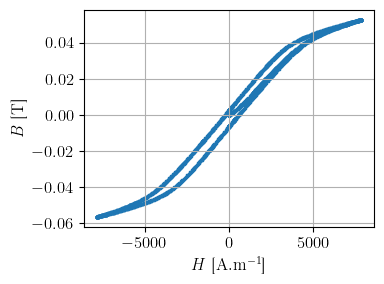

In [58]:
cyl_nickel = pd.read_csv("../data/G1-cylindre-acier-argent-chrome.csv", header=None)

mu_nickel = mu.get("G1-cylindre-acier-argent-chrome")

print(C1_cylindre(mu_nickel), C2_cylindre(mu_nickel))
plt.scatter(C1_cylindre(mu_nickel).nominal_value*cyl_nickel[0], C2_cylindre(mu_nickel).nominal_value*cyl_nickel[1], marker="s", s=1)
plt.grid()
plt.xlabel(r"$H$ [A.m$^{-1}$]")
plt.ylabel(r"$B$ [T]")
plt.tight_layout()
plt.savefig("../figures/acier-argent-chrome_chang.pdf")